**Ejercicio 1:** Implemente el algoritmo de entrenamiento de un SOM bidimensional de forma que se pueda ver gráficamente el mapa topológico durante todo el proceso. Para poder observar el ordenamiento topológico, en el mapa grafique líneas de unión entre pares de neuronas vecinas. Realice las pruebas de ordenamiento topológico con los patrones provistos en los archivos circulo.csv y te.csv, usando un máximo de 1000 épocas de entrenamiento.

#### <b>Librerías</b>

In [14]:
import numpy as np
import time
import math
import copy
import matplotlib.pyplot as plt

#### **Entrenamiento:**

Hacemos una función genérica que funcione con los argumentos que le pasemos. Para los argumentos rv y mu, pasamos un estado inicial y otro final que nos va a servir para la etapa de transición. Para las etapas con rv y mu constante, el inicial va a ser igual al final y no va a haber cambios en las épocas.

Inicializamos al azar (entre -0.5 y 0.5) los pesos para todas las neuronas del SOM en un vector de tamaño filas*columnas con los vectores de coordenadas de cada neurona. Otra alternativa para la inicialización de los pesos podría ser escoger al azar una entrada para cada neurona y asignarla como peso.

Para este caso, a modo de simplificación, los pesos serán actualizados teniendo en cuenta una distancia cuadrada (actualización es la misma para neurona ganadora y sus vecinas, en vez de usar una gaussiana o similares que actualizan en menor medida los pesos según la distancia a la ganadora).

In [15]:
def som_train(inputs,W,max_epocas,v_rv,v_mu,tol):
    W_last = copy.deepcopy(W)
    filas,columnas=W.shape
    inicio = time.time()
    for epoca in range(max_epocas):
        for input in inputs:
            # Decrecimiento de los parámetros para etapa de transición:
            step = (v_mu[0] - v_mu[1])/max_epocas
            mu = v_mu[0] - epoca*step             # Si v_mu[0] = v_mu[1], step = 0 y mu no se modifica.
            step = (v_rv[0] - v_rv[1])/max_epocas
            rv = round(v_rv[0] - epoca*step)      # Lo mismo para rv.

            # Obtengo neurona ganadora buscando peso de menor distancia en W:
            dist = [[np.linalg.norm(input - w) for w in row] for row in W]
            indice = np.unravel_index(np.argmin(dist),W.shape)
            
            # Me tengo que fijar que no se me vaya a índices negativos o fuera de los límites de la matriz
            for k in range(0,rv+1):                 # Empieza en 0 para hacer la fila de la neurona ganadora      
                d = indice[0] + k                   # Me desplazo una fila abajo
                if (d < filas):
                    W[d,indice[1]] += mu*(input - W[d,indice[1]])
                    for j in range(1,rv+1-k):       # En esa fila, voy a la izquierda
                        dL = indice[1] - j
                        if(dL > -1): W[d,dL] += mu*(input - W[d,dL])
                        else: break
                    for j in range(1,rv+1-k):       # En esa fila, voy a la derecha
                        dR = indice[1] + j
                        if(dR < columnas): W[d,dR] += mu*(input - W[d,dR])
                        else: break
                else: break
            
            for k in range(1,rv+1):               # Empieza en 1 porque ya hice la fila de la neurona ganadora antes
                d = indice[0] - k                 # Me desplazo una fila arriba
                if (d > -1):
                    W[d,indice[1]] += mu*(input - W[d,indice[1]])
                    for j in range(1,rv+1-k):       # En esa fila, voy a la izquierda
                        dL = indice[1] - j
                        if(dL > -1): 
                            W[d,dL] += mu*(input - W[d,dL])
                        else: break
                    for j in range(1,rv+1-k):       # En esa fila, voy a la derecha
                        dR = indice[1] + j
                        if(dR < columnas): W[d,dR] += mu*(input - W[d,dR])
                        else: break
                else: break

        W_last = copy.deepcopy(W)
        epoca += 1
    
    fin = time.time()
    print('El entrenamiento finalizó en la época',epoca,'en',round(fin-inicio,2),'segundos.')

    return W_last

Hacemos una función auxiliar para graficar los resultados en las distintas etapas:

In [16]:
def grafica_som(inputs,W):
    fig,ax = plt.subplots()
    ax.set(xlim=[-1.5,1.5],ylim=[-1.5,1.5],title='Distribución final de pesos')

    # Patrones de entrada
    ax.scatter(inputs[:,0], inputs[:,1], marker='x', color='grey')  

    # Neuronas
    filas,columnas=W.shape
    x = np.array([[W[i, j][0] for j in range(columnas)] for i in range(filas)])
    y = np.array([[W[i, j][1] for j in range(columnas)] for i in range(filas)])
    ax.scatter(x.ravel(),y.ravel(),marker='o',color='blue')

    # Conexiones entre neuronas:
    for i in range(filas):   
        for j in range(columnas):
            w1 = W[i,j]

            d1 = i + 1          # Me desplazo una fila abajo
            if(d1 < filas):                
                w2 = W[d1,j]
                ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color='black')
            
            d2 = i - 1          # Me desplazo una fila arriba
            if(d2 > -1):                
                w2 = W[d2,j]
                ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color='black')

            d3 = j - 1          # Me desplazo una columna a la izquierda
            if(d3 > -1):
                w2 = W[i,d3]
                ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color='black')

            d4 = j + 1          # Me desplazo una columna a la derecha
            if(d4 < columnas):
                w2 = W[i,d4]
                ax.plot([w1[0],w2[0]],[w1[1],w2[1]],color='black')
    plt.show()

#### **a) Estructura 5x5 de la red:**

Seteamos los argumentos generales que se comparten entre las tres etapas de entrenamiento del SOM

In [17]:
filas = 5          # Filas de neuronas
columnas = 5       # Columnas de neuronas
tol = 1e-8         # Tolerancia de error para indicar convergencia
mu_ini = 0.9       # Esta va a ser la velocidad de aprendizaje de la primera etapa y al principio de la segunda etapa

#### **Primera etapa: Ordenamiento global**

Esta etapa tiene como máximo 500-1000 épocas, una velocidad de aprendizaje alta (0.7-0.9) y un radio de vecinos alto (más o menos la mitad del mapa neuronal). Usamos 30 épocas porque es un problema sencillo.


El entrenamiento finalizó en la época 30 en 2.09 segundos.


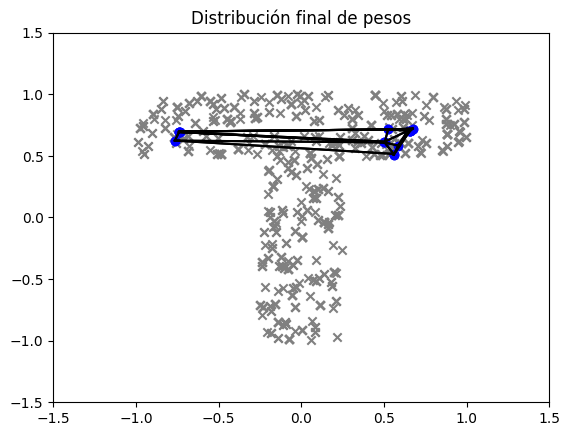

In [18]:
mitad_mapa = math.ceil(max(filas,columnas)/2)
mu = [mu_ini,mu_ini]                # Velocidad de aprendizaje inicial y final
rv = [mitad_mapa,mitad_mapa]        # Radio de activación inicial y final
max_epocas = 30

inputs = np.loadtxt('./data/te.csv',delimiter=',')      # Entradas desde el archivo .csv

W = np.empty([filas,columnas], dtype=object)
for i in range(filas):
    for j in range(columnas):
        W[i,j] = np.random.rand(len(inputs[0]))-0.5

W = som_train(inputs,W,max_epocas,rv,mu,tol)            # Entrenamiento
grafica_som(inputs,W)                                   # Gráfica

#### **Segunda etapa: Transición**

Esta etapa tiene como máximo 1000 épocas, una velocidad de aprendizaje decreciente (empiezo con la velocidad de aprendizaje de la etapa anterior y decrece lineal o exponencialmente hasta 0.1) y un radio de vecinos también decreciente (vamos desde el radio de vecinos inicial hasta 1). Como es un problema sencillo, podemos setear el máximo de épocas en 300.


El entrenamiento finalizó en la época 300 en 19.91 segundos.


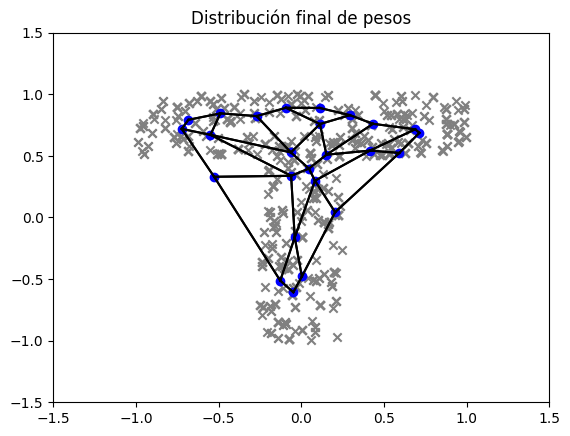

In [19]:
mu = [mu_ini,0.1]          # Velocidad de aprendizaje inicial y final
rv = [mitad_mapa,1]        # Radio de activación inicial y final
max_epocas = 300 

# No inicializo pesos, uso los resultantes de la etapa anterior.
W = som_train(inputs,W,max_epocas,rv,mu,tol)     # Entrenamiento
grafica_som(inputs,W)                            # Gráfica

#### **Tercera etapa: Ajuste fino (convergencia)**

Esta etapa tiene como máximo 3000 épocas, una velocidad de aprendizaje constante entre [0.1,0.01] y un radio de vecinos constante e igual a 0 (sólo actualizamos la neurona ganadora). Como es un problema sencillo, seteamos el máximo de épocas en 50.


El entrenamiento finalizó en la época 50 en 2.87 segundos.


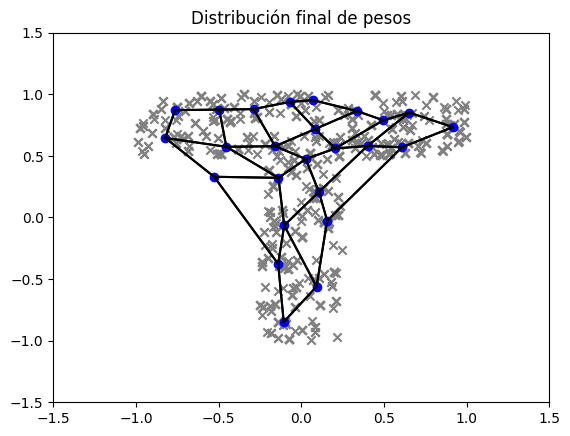

In [20]:
mu = [0.01,0.01]    # Velocidad de aprendizaje inicial y final
rv = [0,0]          # Radio de activación inicial y final
max_epocas = 50 

# No inicializo pesos, uso los resultantes de la etapa anterior.
W = som_train(inputs,W,max_epocas,rv,mu,tol)     # Entrenamiento
grafica_som(inputs,W)                            # Gráfica

#### **b) Estructura 1x25 de la red**

Probamos el mismo problema, dándole sus tres etapas, pero con una estructura de red neuronal unidimensional con la misma cantidad de neuronas.
Previamente teníamos 5x5, esto es, 25 neuronas en una grilla cuadrada. Ahora ponemos 25 neuronas en una sola fila y mantenemos los mismos parámetros para todo lo demás.

In [21]:
filas = 1          # Filas de neuronas
columnas = 25       # Columnas de neuronas
tol = 1e-8         # Tolerancia de error para indicar convergencia
mu_ini = 0.9       # Esta va a ser la velocidad de aprendizaje de la primera etapa y al principio de la segunda etapa

#### **Primera etapa: Ordenamiento global**


El entrenamiento finalizó en la época 30 en 2.34 segundos.


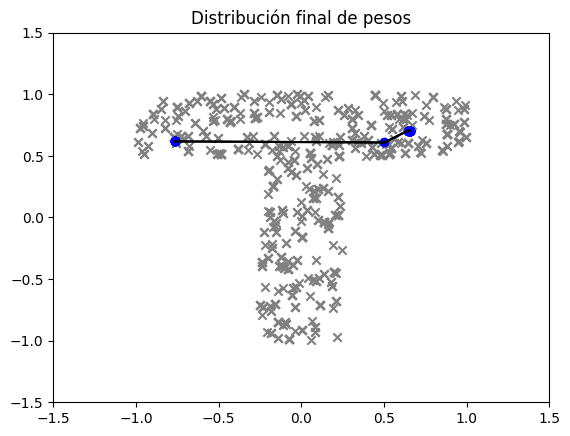

In [22]:
mitad_mapa = math.ceil(max(filas,columnas)/2)
mu = [mu_ini,mu_ini]                # Velocidad de aprendizaje inicial y final
rv = [mitad_mapa,mitad_mapa]        # Radio de activación inicial y final
max_epocas = 30

W = np.empty([filas,columnas], dtype=object)
for i in range(filas):
    for j in range(columnas):
        W[i,j] = np.random.rand(len(inputs[0]))-0.5

W = som_train(inputs,W,max_epocas,rv,mu,tol)            # Entrenamiento
grafica_som(inputs,W)                                   # Gráfica

#### **Segunda etapa: Transición**

El entrenamiento finalizó en la época 500 en 34.84 segundos.


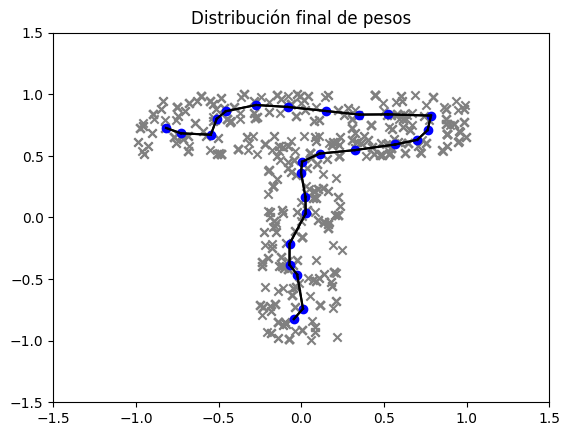

In [23]:
mu = [mu_ini,0.1]          # Velocidad de aprendizaje inicial y final
rv = [mitad_mapa,1]        # Radio de activación inicial y final
max_epocas = 500 

# No inicializo pesos, uso los resultantes de la etapa anterior.
W = som_train(inputs,W,max_epocas,rv,mu,tol)     # Entrenamiento
grafica_som(inputs,W)                            # Gráfica

#### **Tercera etapa: Ajuste fino (convergencia)**

El entrenamiento finalizó en la época 50 en 2.67 segundos.


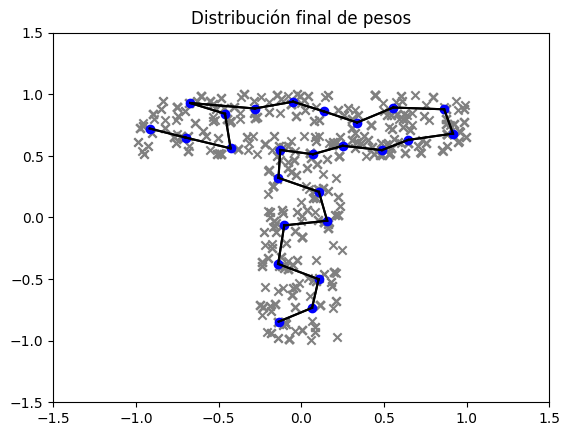

In [24]:
mu = [0.01,0.01]    # Velocidad de aprendizaje inicial y final
rv = [0,0]          # Radio de activación inicial y final
max_epocas = 50 

# No inicializo pesos, uso los resultantes de la etapa anterior.
W = som_train(inputs,W,max_epocas,rv,mu,tol)     # Entrenamiento
grafica_som(inputs,W)                            # Gráfica